In [1]:
from GeoGuesserSystem import *

ModuleNotFoundError: No module named 'utils'

In [2]:
GLOBAL_SYSTEMS_PATH

NameError: name 'GLOBAL_SYSTEMS_PATH' is not defined

In [3]:
BR = system_loader()

NameError: name 'GLOBAL_SYSTEMS_PATH' is not defined

In [2]:
train_dataloader, test_dataloader, pct_n, shp_n, pct, shp, countries, DFO = process_data()

NeuralNetwork = model_loader(force_override=False)

In [14]:
BR = BRAIN()
BR.NN = NeuralNetwork
BR.train_dataloader = train_dataloader
BR.test_dataloader = test_dataloader
BR.loss_function = HaversineLoss
BR.tau = 100
BR.pct_n = pct_n
BR.pct = pct
BR.shp_n = shp_n
BR.shp = shp
BR.device = 'cuda'

In [5]:
import pandas as pd

In [6]:
import pickle

with open('model_full.pkl', 'rb') as file:
    BR = pickle.load(file)

ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

In [16]:
BR.prepare_system(list(countries))

In [17]:
BR.train(1)

  9%|▉         | 438/4683 [07:55<1:16:52,  1.09s/it]


KeyboardInterrupt: 

In [9]:
BR.train(2)

100%|██████████| 1201/1201 [21:24<00:00,  1.07s/it]


69759.16161193445


100%|██████████| 1201/1201 [21:23<00:00,  1.07s/it]


69392.54305489962


100%|██████████| 1201/1201 [21:24<00:00,  1.07s/it]


69210.49973642667


100%|██████████| 1201/1201 [21:24<00:00,  1.07s/it]


69001.89233682354


100%|██████████| 1201/1201 [21:23<00:00,  1.07s/it]


68935.3892173018


100%|██████████| 1201/1201 [21:23<00:00,  1.07s/it]


68758.02552761245


100%|██████████| 1201/1201 [21:23<00:00,  1.07s/it]


68589.3757673904


100%|██████████| 1201/1201 [21:23<00:00,  1.07s/it]


68524.32961166784


100%|██████████| 1201/1201 [21:23<00:00,  1.07s/it]


68432.8401493935


100%|██████████| 1201/1201 [21:22<00:00,  1.07s/it]

68381.84844459355


In [ ]:
BR.train(10)

In [10]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(BR, file)

100%|██████████| 300/300 [05:24<00:00,  1.08s/it]


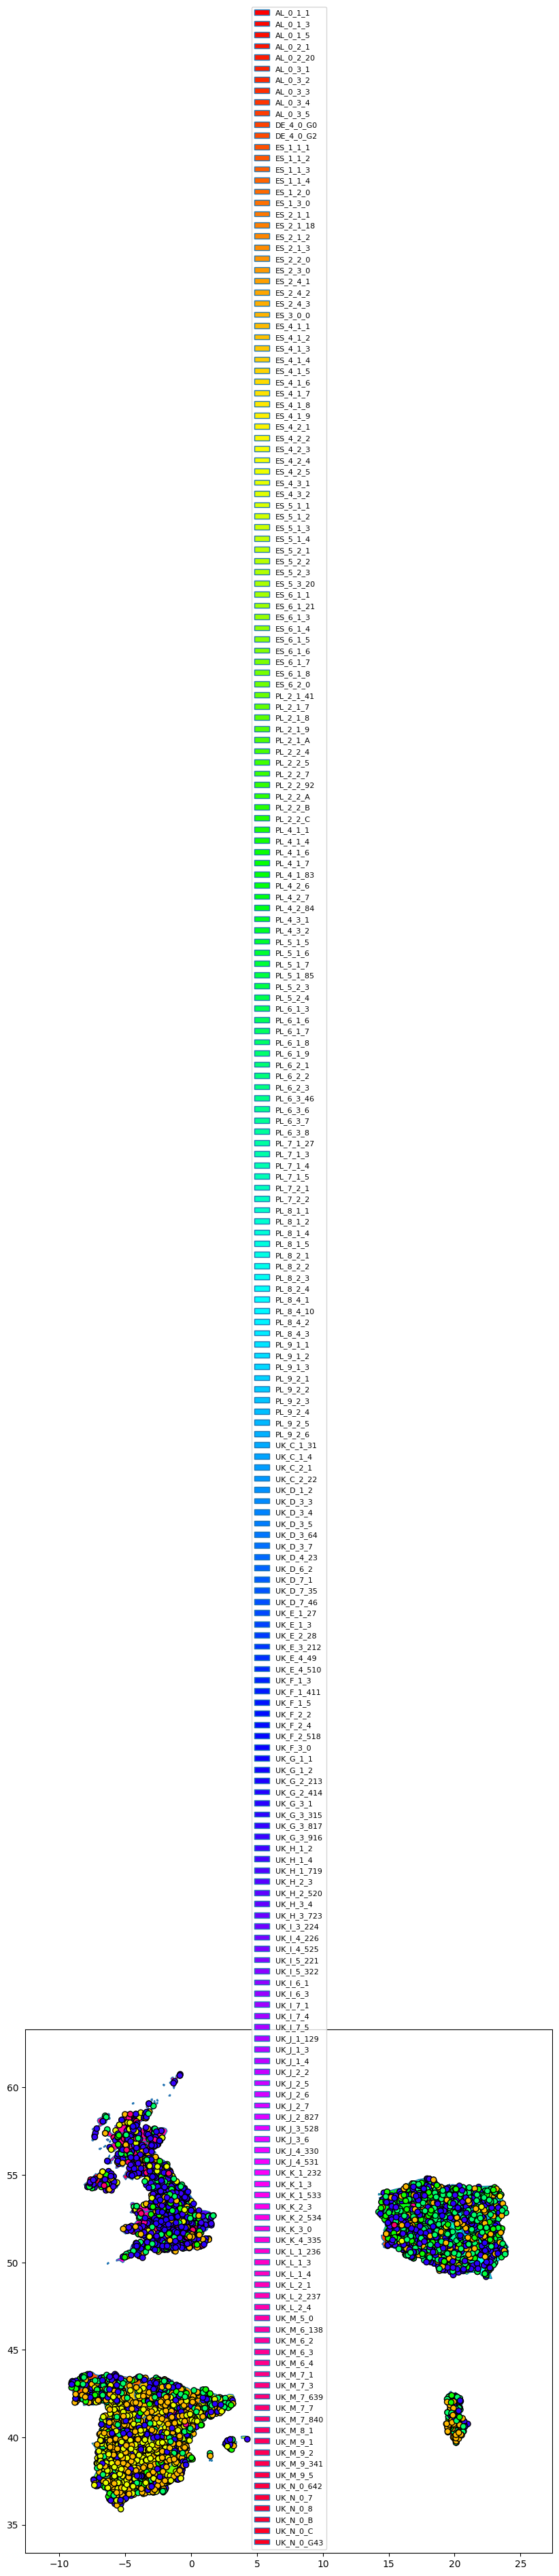

In [ ]:
BR.test_main(True)

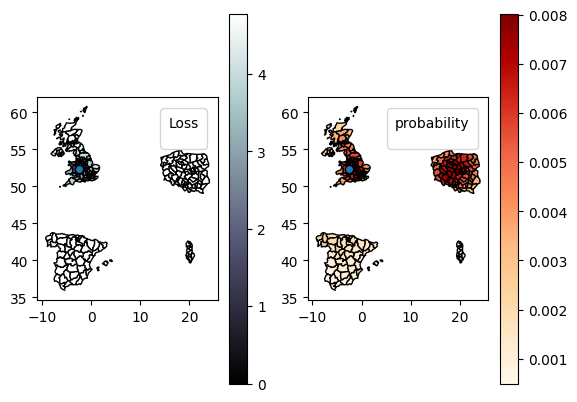

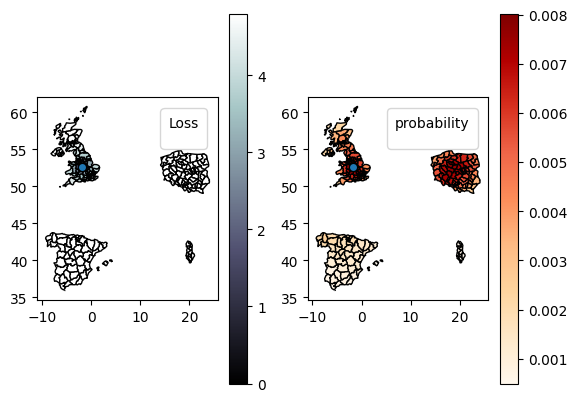

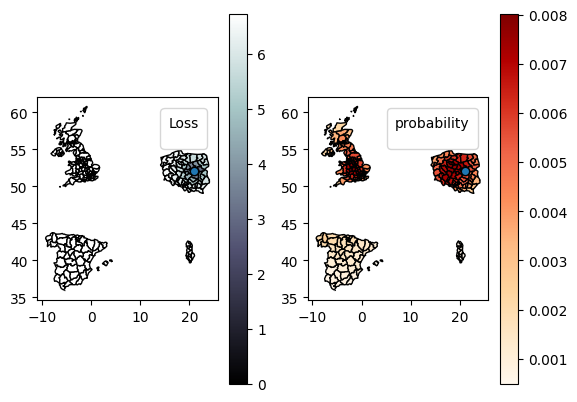

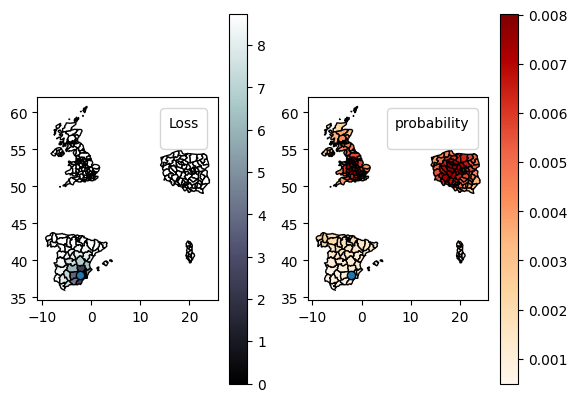

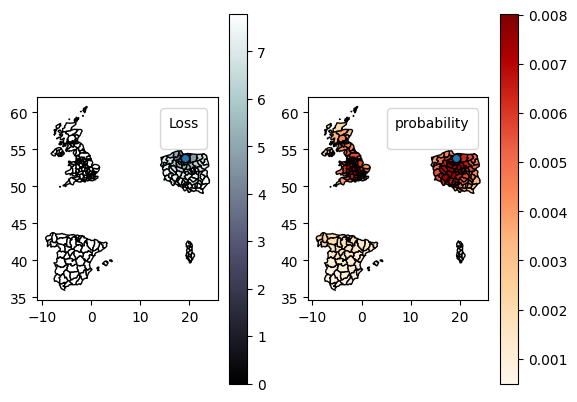

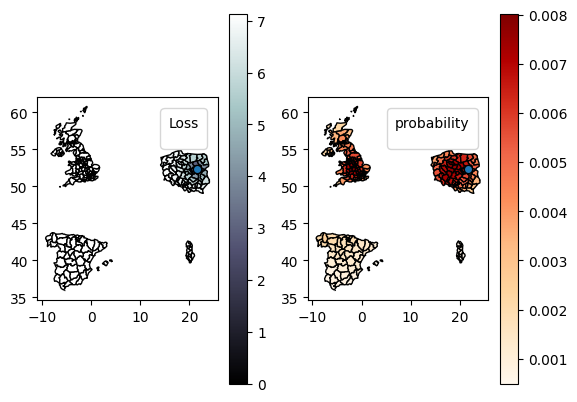

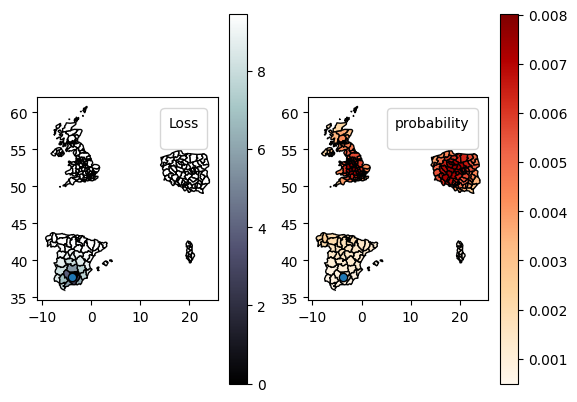

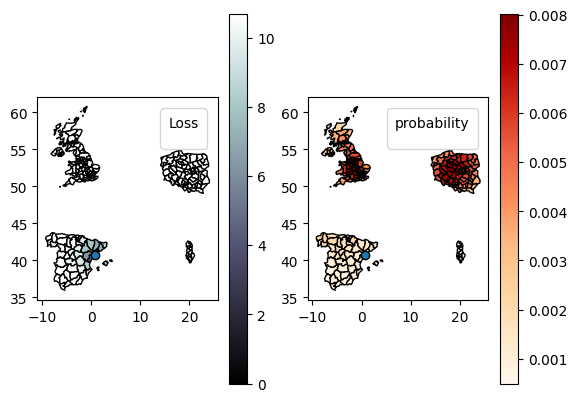

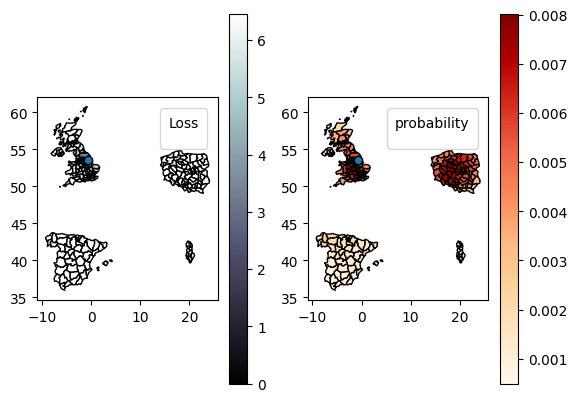

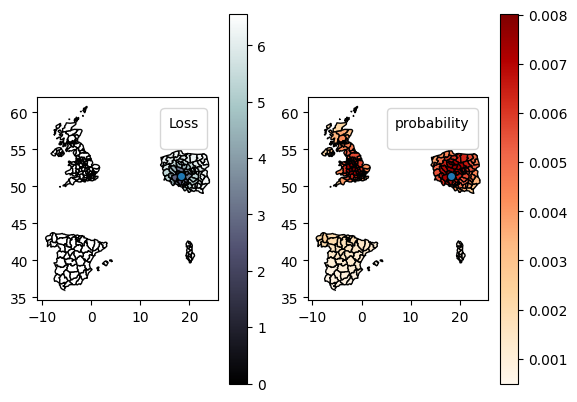

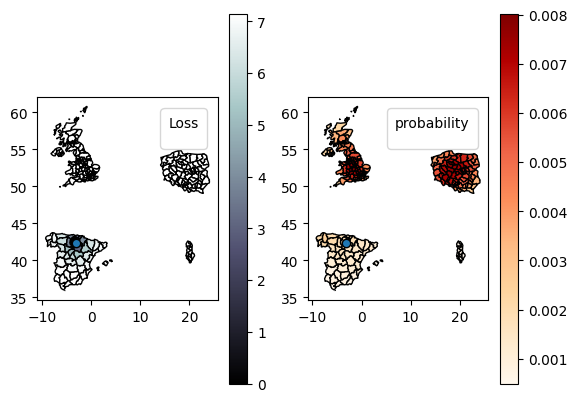

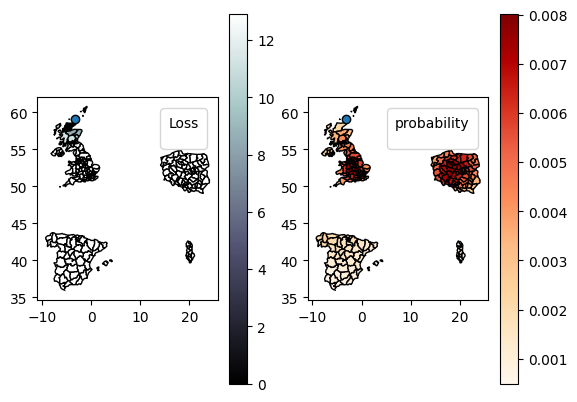

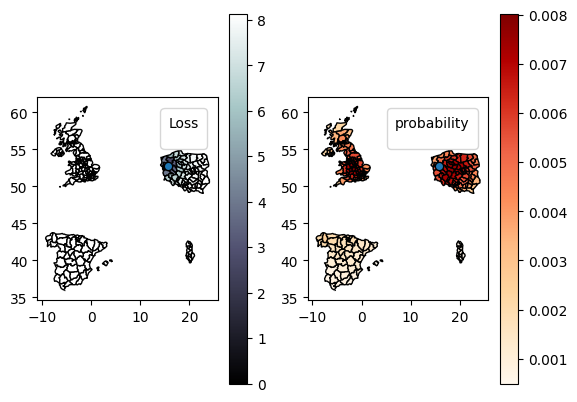

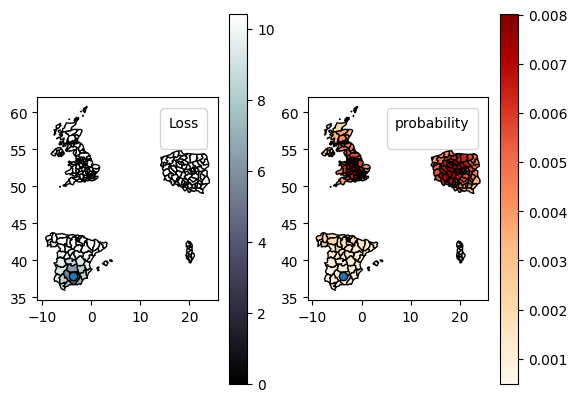

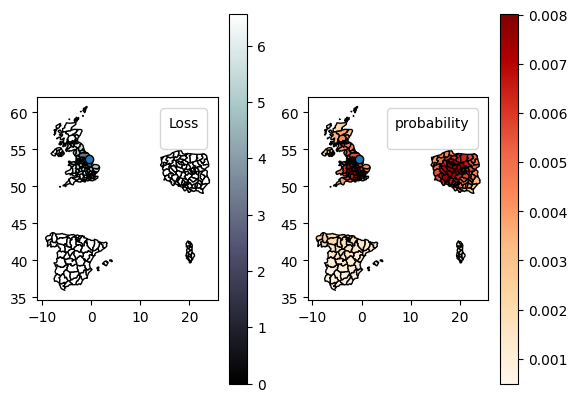

In [12]:
loss_prop, gradient_analysis = BR.asses_photos(data=next(iter(BR.test_dataloader)))

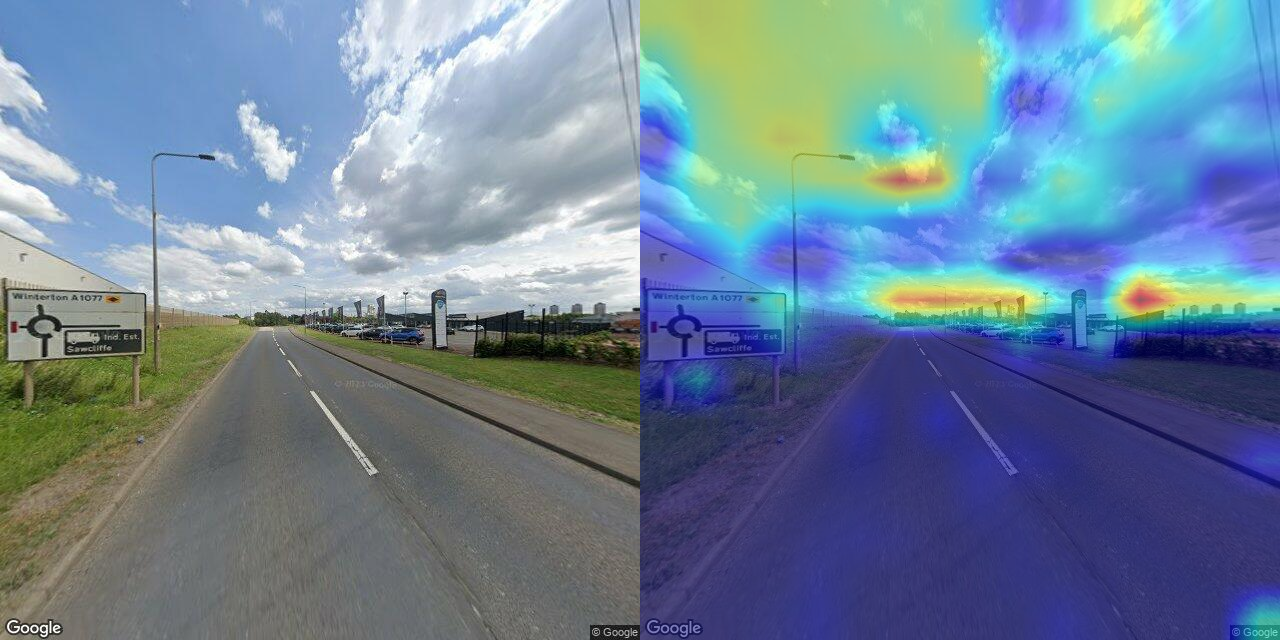

In [44]:
gradient_analysis[8]

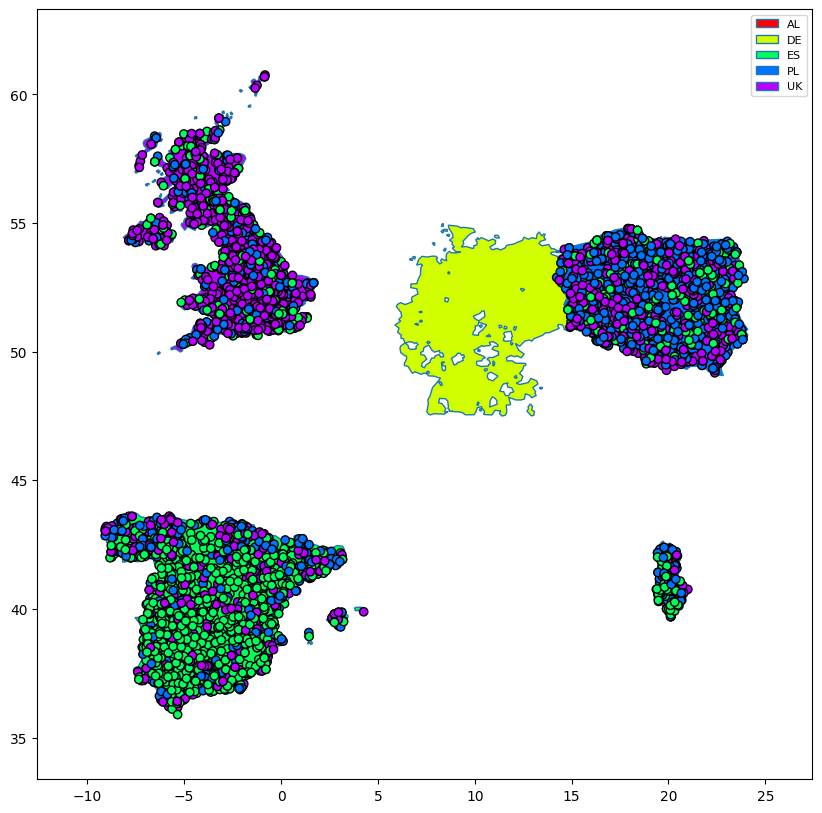

In [37]:
occurences2, colors2, shp2, df12 = precision_level_set(BR.total_occurences, BR.shp, 1)
plot_predicted_points(shp2, colors2, occurences2, df12, BR.cords_list);

In [38]:
pd.DataFrame(occurences2).groupby(0)[1].value_counts().unstack(-1).reindex(pd.DataFrame(occurences2)[0].unique(), axis=1).fillna(0).sort_index(axis=1).sort_index(axis=0).to_excel('first_res.xlsx')